# Latent Consistency Model using Optimum-Intel OpenVINO on AI PC
This notebook provides instructions how to run Latent Consistency Model (LCM) on AI PC. It allows to setup standard Hugging Face diffusers pipeline and Optimum Intel pipeline optimized for Intel hardware including CPU and integrated GPU (iGPU). Running inference on CPU and iGPU it is easy to compare performance and time required to generate an image for provided prompt. The notebook can be also used on other Intel hardware with minimal or no modifications.  

![](https://github.com/openvinotoolkit/openvino_notebooks/assets/10940214/1858dae4-72fd-401e-b055-66d503d82446)

Optimum Intel is an interface from Hugging Face between both diffusers and transformers libraries and various tools provided by Intel to accelerate pipelines on Intel hardware. It allows to perform quantization of the models hosted on Hugging Face.
In this notebook OpenVINO is used for AI-inference acceleration as a backend for Optimum Intel! 

For more details please refer to Optimum Intel repository
https://github.com/huggingface/optimum-intel

<img src="lcm.png"/>

LCMs are the next generation of generative models after Latent Diffusion Models (LDMs). They are proposed to overcome the slow iterative sampling process of Latent Diffusion Models (LDMs), enabling fast inference with minimal steps (from 2 to 4) on any pre-trained LDMs (e.g. Stable Diffusion). To read more about LCM please refer to https://latent-consistency-models.github.io/

#### Table of contents:
- [Prerequisites](#Prerequisites)
- [Full precision model on the CPU](#Using-full-precision-model-in-CPU-with-LatentConsistencyModelPipeline)
- [Full precision model on the CPU with OpenVINO acceleration](#Using-full-precision-model-in-CPU-with-OVLatentConsistencyModelPipeline)
- [Running AI-inference on the GPU with OpenVINO acceleration](#Running-inference-on-iGPU-with-OVLatentConsistencyModelPipeline)


### Prerequisites
[back to top ⬆️](#Table-of-contents:)

Install required packages

In [1]:
%pip install -q "optimum-intel[openvino,diffusers]@git+https://github.com/huggingface/optimum-intel.git" "ipywidgets" "transformers>=4.33.0" --extra-index-url https://download.pytorch.org/whl/cpu

Note: you may need to restart the kernel to use updated packages.


In [2]:
import warnings
warnings.filterwarnings('ignore')

### Showing Info Available Devices
[back to top ⬆️](#Table-of-contents:)

The `available_devices` property shows the available devices in your system. The "FULL_DEVICE_NAME" option to `ie.get_property()` shows the name of the device. Check what is the ID name for the discrete GPU, if you have integrated GPU (iGPU) and discrete GPU (dGPU), it will show `device_name="GPU.0"` for iGPU and `device_name="GPU.1"` for dGPU. If you just have either an iGPU or dGPU that will be assigned to `"GPU"`

Note: For more details about GPU with OpenVINO visit this [link](https://docs.openvino.ai/nightly/openvino_docs_install_guides_configurations_for_intel_gpu.html). If you have been facing any issue in Ubuntu 20.04 or Windows 11 read this [blog](https://blog.openvino.ai/blog-posts/install-gpu-drivers-windows-ubuntu).

In [3]:
from openvino.runtime import Core

core = Core()
devices = core.available_devices

for device in devices:
    device_name = core.get_property(device, "FULL_DEVICE_NAME")
    print(f"{device}: {device_name}")

CPU: Intel(R) Core(TM) Ultra 7 155H
GNA.GNA_SW: GNA_SW
GNA.GNA_HW: GNA_HW
GPU: Intel(R) Arc(TM) Graphics (iGPU)
NPU: Intel(R) AI Boost


### Using full precision model in CPU with `LatentConsistencyModelPipeline`
[back to top ⬆️](#Table-of-contents:)
Standard pipeline for the Latent Consistency Model(LCM) from Diffusers library is used here. For more information please refer to  https://huggingface.co/docs/diffusers/en/api/pipelines/latent_consistency_models


In [4]:
from diffusers import LatentConsistencyModelPipeline
import gc

pipeline = LatentConsistencyModelPipeline.from_pretrained("SimianLuo/LCM_Dreamshaper_v7")
pipeline.save_pretrained("./cpu")



Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

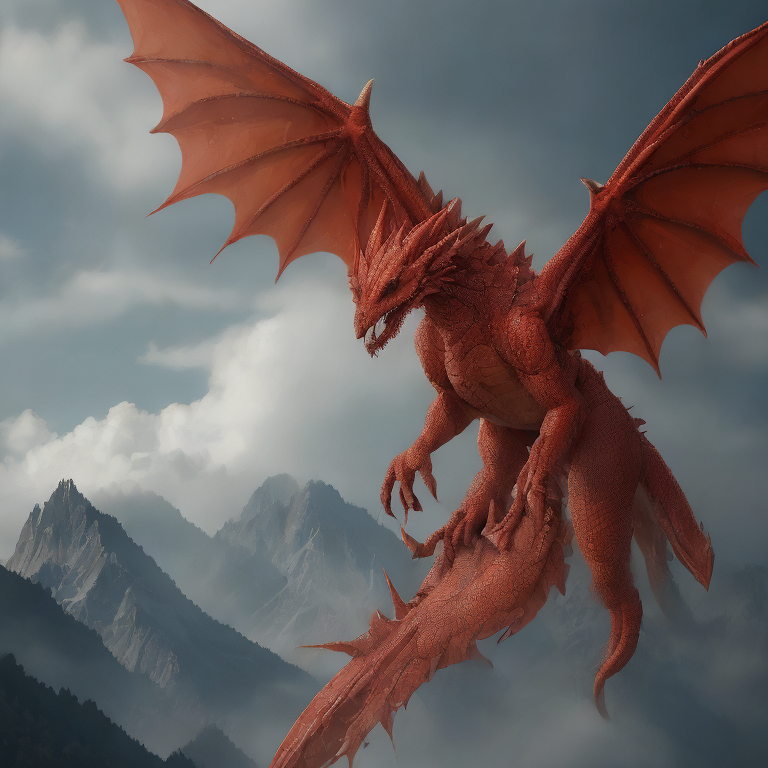

In [8]:
prompt = "Red wood dragon flying in the sky 8k"

image = pipeline(
    prompt=prompt, num_inference_steps=4, guidance_scale=8.0
).images[0]
image.save("image_cpu.png")
image

In [9]:
del pipeline
gc.collect()

348

### Using full precision model in CPU with `OVLatentConsistencyModelPipeline`
[back to top ⬆️](#Table-of-contents:)
Accelerating inference of LCM using Intel Optimum with OpenVINO backend. For more information please refer to https://huggingface.co/docs/optimum/intel/inference#latent-consistency-models


In [ ]:
from optimum.intel import OVLatentConsistencyModelPipeline

ov_pipeline = OVLatentConsistencyModelPipeline.from_pretrained("SimianLuo/LCM_Dreamshaper_v7", export=True, compile=False)
ov_pipeline.reshape(batch_size=1, height=768, width=768, num_images_per_prompt=1)
ov_pipeline.save_pretrained("./openvino_ir")
ov_pipeline.compile()

  0%|          | 0/4 [00:00<?, ?it/s]

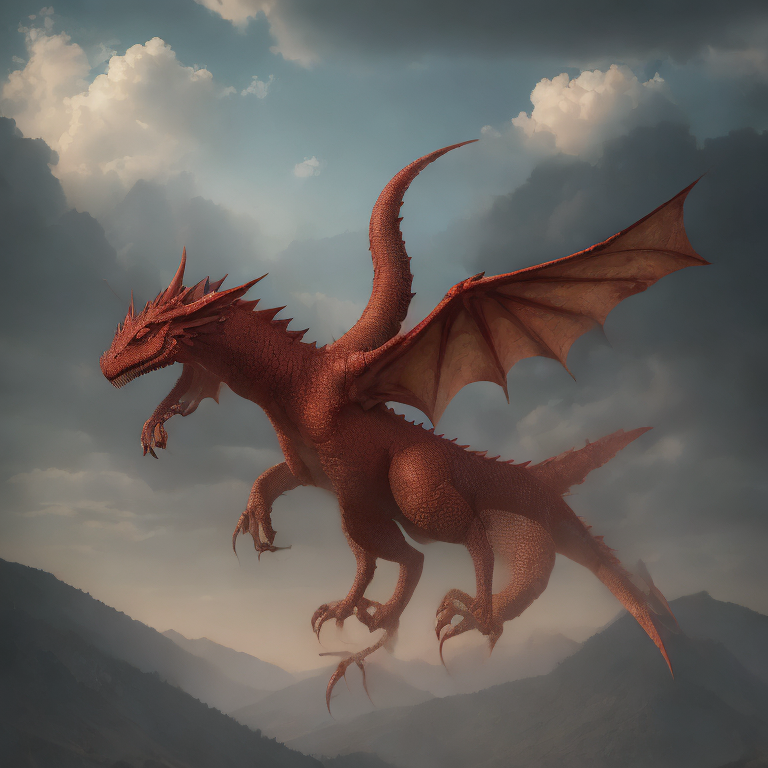

In [11]:
image_ov_cpu = ov_pipeline(prompt=prompt, num_inference_steps=4, guidance_scale=8.0).images[0]
image_ov_cpu.save("image_opt_cpu.png")
image_ov_cpu

### Running inference on iGPU with `OVLatentConsistencyModelPipeline`
[back to top ⬆️](#Table-of-contents:)

The model in this notebook is FP32 precision, but accelerated AI-inference is supported for FP16 data type and FP32 precision for GPU may produce high memory footprint and latency. Therefore default precision for GPU in OpenVINO is FP16. OpenVINO GPU Plugin converts FP32 to FP16 on the fly and there is no need to do it manually.  

In [12]:
ov_pipeline.to("GPU")
ov_pipeline.compile()

Compiling the vae_decoder to GPU ...
Compiling the unet to GPU ...
Compiling the vae_encoder to GPU ...
Compiling the text_encoder to GPU ...


  0%|          | 0/4 [00:00<?, ?it/s]

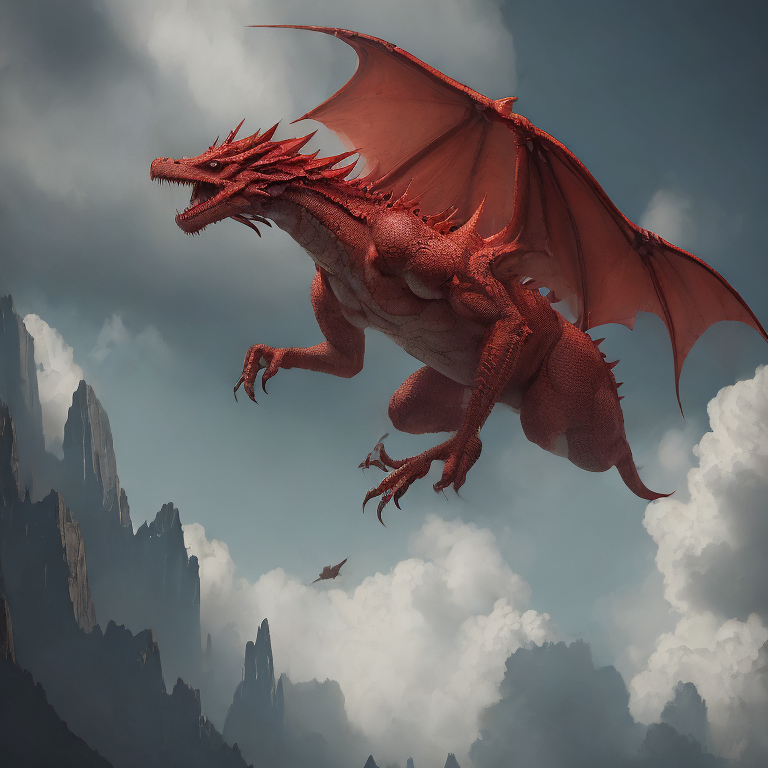

In [27]:
prompt = "Red wood dragon flying in the sky 8k"
image_ov_gpu = ov_pipeline(prompt=prompt, num_inference_steps=4, guidance_scale=8.0).images[0]
image_ov_gpu.save("image_opt_gpu.png")
image_ov_gpu

In [28]:
del ov_pipeline
gc.collect()

8273